This notebook visulaizes the replicate correlation of STARR-seq and MPRA experiments. 

To proceed with this analysis, you need to:
(1) run 4_calculate_replicate_correlation.py, and 
(2) specify the directory to results of the  4_calculate_replicate_correlation.py script. 

In [1]:
import argparse
import gzip
import os
import sys

import pandas as pd
import numpy as np

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# Dynamically add src directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)

import pybedtools
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/')



In [2]:
# Set the project root directory (assuming current working directory is within a subdirectory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))


In [3]:
# https://gensoft.pasteur.fr/docs/deepTools/3.4.1/content/feature/effectiveGenomeSize.html

hg38_effective_genome_size = 2913022398


In [4]:
# ------------------------------------------
# Load and calculate total coverage of open chromatin regions
# ------------------------------------------

# Define the path to the BED file containing ATAC-seq peaks (used as open regions)
data_path = os.path.join(
    project_root,
    'data',
    'reference',
    'K562_ATAC_seq_based_on_DNA_in_ATAC_STARR_seq',
    'KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.bed'
)

# Load the BED file using pybedtools
open_region_bed = pybedtools.BedTool(data_path)

# Calculate the total number of bases covered by open chromatin regions
open_region_size = open_region_bed.total_coverage()

# Print the total coverage size
print(open_region_size)


198066259


In [10]:
def calc_bp_intersect_region(query_bed, region_bed):
    """
    Calculate the number of base pairs from a BED file that intersect with a given region.

    Parameters:
        query_bed (pybedtools.BedTool): A BedTool object represeting the queried region(s).
        region_bed (pybedtools.BedTool): A BedTool object representing the reference region(s).

    Returns:
        int: Total number of base pairs from the input file that overlap with the region_bed.
    """
    
    # Merge overlapping intervals in query bed 
    merged_bed = query_bed.merge()

    # Merge overlapping regions in the reference region bed
    region_bed = region_bed.merge()

    # Calculate coverage of merged_bed fragments within the region_bed
    bed_coverage_on_region = region_bed.coverage(merged_bed)

    # Convert coverage result to DataFrame
    bed_coverage_on_region = bed_coverage_on_region.to_dataframe(
        disable_auto_names=True,
        header=None
    )

    # Sum the number of overlapping base pairs (3rd column from the end)
    num_bp = np.sum(bed_coverage_on_region[bed_coverage_on_region.columns[-3]].values)

    return num_bp

# Calculate coverage of all assayed regions

Assayed coverage refers to the total genomic space from which DNA fragments were selected and introduced into the reporter library—essentially, the potential search space that the experiment is designed to evaluate. In contrast, tested coverage represents the subset of that space for which there is sufficient signal (e.g., RNA and DNA counts passing filtering thresholds) to enable a statistical assessment of activity. While assayed coverage reflects the experiment’s breadth, tested coverage highlights the portion where functional conclusions can actually be drawn. 

## TilingMPRA

### OL13

In [6]:
# ------------------------------------------
# Calculate total genomic coverage of OL13 tiled fragments (assayed regions)
# ------------------------------------------

# Define the file path for processed count data with annotation
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'TilingMPRA',
    'OL13_ENCSR394HXI',
    'processed_OL13_count_with_all_annotation.txt'
)

# Load the full fragment annotation table
all_frag = pd.read_csv(data_path, sep='\t')

# Filter to include only tile-derived fragments and select BED-format columns
all_frag = all_frag[all_frag['project'] == 'Tiles'][['seqnames', 'start', 'end', 'strand']]

# Sort fragments
all_frag = all_frag.sort_values(['seqnames', 'start'])

# Print the number of tiled fragments
print(f"Number of tiled fragments: {len(all_frag)}")

# Convert DataFrame to BedTool object and merge overlapping regions
ol13_all_frag_bed = pybedtools.BedTool.from_dataframe(all_frag)
ol13_all_frag_bed = ol13_all_frag_bed.merge()

# Calculate total base-pair coverage of merged tiled regions
ol13_all_frag_bp = ol13_all_frag_bed.total_coverage()

# Print the total number of base pairs covered
print(f"Total base-pair coverage of tiled fragments (assayed coverage): {ol13_all_frag_bp}")


Number of tiled fragments: 42714
Total base-pair coverage of tiled fragments (assayed coverage): 111020


### OL43

In [7]:
# ------------------------------------------
# Calculate total genomic coverage of OL43 tiled fragments (assayed regions)
# ------------------------------------------

# Define the input file path for OL43 processed count data with annotation
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'TilingMPRA',
    'OL43_ENCSR917SFD',
    'processed_OL43_count_with_all_annotation.txt'
)

# Load the full fragment annotation table
all_frag = pd.read_csv(data_path, sep='\t')
all_frag = all_frag[all_frag['project'].map(lambda x: x is not np.nan)]

# Filter to include only tile-derived fragments and retain BED-format columns
all_frag = all_frag[all_frag['project'].map(lambda x: 'Tiles' in x)][['seqnames', 'start', 'stop', 'strand']]

# Ensure coordinate columns are in integer format as required by pybedtools
all_frag = all_frag.astype({'start': float, 'stop': float})
all_frag = all_frag.astype({'start': int, 'stop': int})

# Sort fragments by chromosome and start position for proper merging
all_frag = all_frag.sort_values(['seqnames', 'start'])

# Display the number of tiled fragments before merging
print(f"Number of tiled fragments: {len(all_frag)}")

# Convert DataFrame to BedTool object and merge overlapping or adjacent regions
ol43_all_frag_bed = pybedtools.BedTool.from_dataframe(all_frag)
ol43_all_frag_bed = ol43_all_frag_bed.merge()

# Compute the total base-pair coverage of merged tiled regions
ol43_all_frag_bp = ol43_all_frag_bed.total_coverage()

# Display the total genomic coverage in base pairs
print(f"Total base-pair coverage of tiled fragments (assayed coverage): {ol43_all_frag_bp}")


Number of tiled fragments: 95990
Total base-pair coverage of tiled fragments (assayed coverage): 3912714


### OL45

In [8]:
# ------------------------------------------
# Calculate total genomic coverage of OL45 tiled fragments (assayed regions)
# ------------------------------------------

# Define the input file path for OL45 processed count data with annotation
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'TilingMPRA',
    'OL45_ENCSR363XER',
    'processed_OL45_count_with_all_annotation.txt'
)

# Load the full fragment annotation table
all_frag = pd.read_csv(data_path, sep='\t')
all_frag = all_frag[all_frag['project'].map(lambda x: x is not np.nan)]

# Filter to include only tile-derived fragments and retain BED-format columns
all_frag = all_frag[all_frag['project'].map(lambda x: 'Tiles' in x)][['seqnames', 'start', 'stop', 'strand']]

# Ensure coordinate columns are in integer format as required by pybedtools
all_frag = all_frag.astype({'start': float, 'stop': float})
all_frag = all_frag.astype({'start': int, 'stop': int})

# Sort fragments by chromosome and start position for proper merging
all_frag = all_frag.sort_values(['seqnames', 'start'])

# Display the number of tiled fragments before merging
print(f"Number of tiled fragments: {len(all_frag)}")

# Convert DataFrame to BedTool object and merge overlapping or adjacent regions
ol45_all_frag_bed = pybedtools.BedTool.from_dataframe(all_frag)
ol45_all_frag_bed = ol45_all_frag_bed.merge()

# Compute the total base-pair coverage of merged tiled regions
ol45_all_frag_bp = ol45_all_frag_bed.total_coverage()

# Display the total genomic coverage in base pairs
print(f"Total base-pair coverage of tiled fragments (assayed coverage): {ol45_all_frag_bp}")


Number of tiled fragments: 91110
Total base-pair coverage of tiled fragments (assayed coverage): 9147135


## LentiMPRA

In [9]:
# ------------------------------------------
# Calculate total genomic coverage of LentiMPRA fragments (assayed regions)
# ------------------------------------------

# Define the input file path for LentiMPRA processed count data with annotation
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'LentiMPRA',
    'UMI_count_with_all_annotation.txt'
)

all_frag = pd.read_csv(data_path, sep='\t')

all_frag = all_frag.dropna(subset=['seqnames'])

all_frag = all_frag[all_frag['annot'].map(lambda x: 'control' not in x)][['seqnames', 'start', 'end', 'strand']]

# Ensure coordinate columns are in integer format as required by pybedtools
all_frag = all_frag.astype({'start': float, 'end': float})
all_frag = all_frag.astype({'start': int, 'end': int})

# Sort fragments by chromosome and start position for proper merging
all_frag = all_frag.sort_values(['seqnames', 'start'])

# Display the number of tiled fragments before merging
print(f"Number of tiled fragments: {len(all_frag)}")

# Convert DataFrame to BedTool object and merge overlapping or adjacent regions
lenti_all_frag_bed = pybedtools.BedTool.from_dataframe(all_frag)
lenti_all_frag_bed = lenti_all_frag_bed.merge()

# Compute the total base-pair coverage of merged tiled regions
lenti_all_frag_bp = lenti_all_frag_bed.total_coverage()

# Display the total genomic coverage in base pairs
print(f"Total base-pair coverage of fragments (assayed coverage): {lenti_all_frag_bp}")


Number of tiled fragments: 232542
Total base-pair coverage of fragments (assayed coverage): 23322354


## ATAC-STARR-seq

In [11]:
# ------------------------------------------
# Calculate total genomic coverage of ATAC-STARR-seq all original fragments
# ------------------------------------------

# Define the input file path for ATAC-STARR-seq fragment-level BED file
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'ATAC_STARR_seq',
    'count_mat_original_frag_sorted.bed'
)

# Load the original fragments as a BedTool object
atac_starr_all_frag_bed = pybedtools.BedTool(data_path)

# Display the number of fragments before merging
print(f"Number of original fragments: {len(atac_starr_all_frag_bed)}")

# Merge overlapping or adjacent fragments into contiguous regions
atac_starr_all_frag_bed = atac_starr_all_frag_bed.merge()

# Compute total base-pair coverage across merged regions
atac_starr_all_frag_bp = atac_starr_all_frag_bed.total_coverage()

# Display the total genomic coverage (assayed coverage)
print(f"Total base-pair coverage of fragments (assayed coverage): {atac_starr_all_frag_bp}")


Number of original fragments: 1136262454
Total base-pair coverage of fragments (assayed coverage): 2816174570


In [12]:
# ------------------------------------------
# Calculate total genomic coverage of ATAC-STARR-seq all genomic bins
# ------------------------------------------

# Define the input file path for ATAC-STARR-seq genomic bin-level BED file
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'ATAC_STARR_seq',
    'count_mat_genomic_bin_100bp_stepSize_10bp_sorted.bed'
)

# Load the genomic bin count matrix as a BedTool object
atac_starr_all_bin_bed = pybedtools.BedTool(data_path)

# Display the number of genomic bins before merging
print(f"Number of genomic bins: {len(atac_starr_all_bin_bed)}")

# Merge overlapping or adjacent bins into contiguous regions
atac_starr_all_bin_bed = atac_starr_all_bin_bed.merge()

# Compute total base-pair coverage across merged regions
atac_starr_all_bin_bp = atac_starr_all_bin_bed.total_coverage()

# Display the total genomic coverage (assayed coverage)
print(f"Total base-pair coverage of genomic bins (assayed coverage): {atac_starr_all_bin_bp}")


Number of genomic bins: 557773387
Total base-pair coverage of genomic bins (assayed coverage): 2815841216


In [14]:
# check number of overlapping base pairs in ATAC-seq peak regions

# Compute number of base pairs of all original fragments in ATAC-STARR-seq within ATAC-seq peak regions
atac_starr_all_frag_atac_peak_bp = calc_bp_intersect_region(atac_starr_all_frag_bed, open_region_bed)

# Display the total ATAC-seq peak coverage (assayed coverage)
print(f"Total base-pair coverage of original fragments within ATAC-seq peak regions (assayed coverage): {atac_starr_all_frag_atac_peak_bp}")

# Compute number of base pairs of all genomic bins in ATAC-STARR-seq within ATAC-seq peak regions
atac_starr_all_bin_atac_peak_bp = calc_bp_intersect_region(atac_starr_all_bin_bed, open_region_bed)

# Display the total ATAC-seq peak coverage (assayed coverage)
print(f"Total base-pair coverage of genomic bins within ATAC-seq peak regions (assayed coverage): {atac_starr_all_bin_atac_peak_bp}")



Total base-pair coverage of original fragments within ATAC-seq peak regions (assayed coverage): 198059928
Total base-pair coverage of genomic bins within ATAC-seq peak regions (assayed coverage): 198059816


## WHG-STARR-seq

In [15]:
# ------------------------------------------
# Calculate total genomic coverage of WHG-STARR-seq all original fragments
# ------------------------------------------

# Define the input file path for WHG-STARR-seq fragment-level BED file
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'WHG_STARR_seq',
    'count_mat_original_frag_sorted.bed'
)

# Load the original fragments as a BedTool object
whg_starr_all_frag_bed = pybedtools.BedTool(data_path)

# Display the number of fragments before merging
print(f"Number of original fragments: {len(whg_starr_all_frag_bed)}")

# Merge overlapping or adjacent fragments into contiguous regions
whg_starr_all_frag_bed = whg_starr_all_frag_bed.merge()

# Compute total base-pair coverage across merged regions
whg_starr_all_frag_bp = whg_starr_all_frag_bed.total_coverage()

# Display the total genomic coverage (assayed coverage)
print(f"Total base-pair coverage of fragments (assayed coverage): {whg_starr_all_frag_bp}")


Number of original fragments: 826518557
Total base-pair coverage of fragments (assayed coverage): 2814258311


In [16]:
# ------------------------------------------
# Calculate total genomic coverage of WHG-STARR-seq all genomic bins
# ------------------------------------------

# Define the input file path for WHG-STARR-seq genomic bin-level BED file
data_path = os.path.join(
    project_root,
    'data',
    'count_data',
    'WHG_STARR_seq',
    'count_mat_genomic_bin_100bp_stepSize_10bp_sorted.bed'
)

# Load the genomic bin count matrix as a BedTool object
whg_starr_all_bin_bed = pybedtools.BedTool(data_path)

# Display the number of genomic bins before merging
print(f"Number of genomic bins: {len(whg_starr_all_bin_bed)}")

# Merge overlapping or adjacent bins into contiguous regions
whg_starr_all_bin_bed = whg_starr_all_bin_bed.merge()

# Compute total base-pair coverage across merged regions
whg_starr_all_bin_bp = whg_starr_all_bin_bed.total_coverage()

# Display the total genomic coverage (assayed coverage)
print(f"Total base-pair coverage of genomic bins (assayed coverage): {whg_starr_all_bin_bp}")


Number of genomic bins: 549082586
Total base-pair coverage of genomic bins (assayed coverage): 2812887169


In [17]:
# Organize all assayed coverage results into a dataframe

assayed_coverage_data = [['TilingMPRA\n(ENCSR394HXI)', 'Assayed', 'Genome-wide', ol13_all_frag_bp, hg38_effective_genome_size, open_region_size, ol13_all_frag_bp/hg38_effective_genome_size*100, np.nan], 
                         ['TilingMPRA\n(ENCSR363XER)', 'Assayed', 'Genome-wide', ol45_all_frag_bp, hg38_effective_genome_size, open_region_size, ol45_all_frag_bp/hg38_effective_genome_size*100, np.nan], 
                         ['TilingMPRA\n(ENCSR917SFD)', 'Assayed', 'Genome-wide', ol43_all_frag_bp, hg38_effective_genome_size, open_region_size, ol43_all_frag_bp/hg38_effective_genome_size*100, np.nan], 
                         ['LentiMPRA', 'Assayed', 'Genome-wide', lenti_all_frag_bp, hg38_effective_genome_size, open_region_size, lenti_all_frag_bp/hg38_effective_genome_size*100, np.nan], 
                         ['ATAC-STARR-seq\n(All Fragments)', 'Assayed', 'Genome-wide', atac_starr_all_frag_bp, hg38_effective_genome_size, open_region_size, atac_starr_all_frag_bp/hg38_effective_genome_size*100, np.nan], 
                         ['ATAC-STARR-seq\n(All Bins)', 'Assayed', 'Genome-wide', atac_starr_all_bin_bp, hg38_effective_genome_size, open_region_size, atac_starr_all_bin_bp/hg38_effective_genome_size*100, np.nan], 
                         ['ATAC-STARR-seq\n(Accessible Fragments)', 'Assayed', 'Open_region', atac_starr_all_frag_atac_peak_bp, hg38_effective_genome_size, open_region_size, atac_starr_all_frag_atac_peak_bp/hg38_effective_genome_size*100, atac_starr_all_frag_atac_peak_bp/open_region_size*100], 
                         ['ATAC-STARR-seq\n(Accessible Bins)', 'Assayed', 'Open_region', atac_starr_all_bin_atac_peak_bp, hg38_effective_genome_size, open_region_size, atac_starr_all_bin_atac_peak_bp/hg38_effective_genome_size*100, atac_starr_all_bin_atac_peak_bp/open_region_size*100], 
                         ['WHG-STARR-seq\n(All Fragments)', 'Assayed', 'Genome-wide', whg_starr_all_frag_bp, hg38_effective_genome_size, open_region_size, whg_starr_all_frag_bp/hg38_effective_genome_size*100, np.nan], 
                         ['WHG-STARR-seq\n(All Bins)', 'Assayed', 'Genome-wide', whg_starr_all_bin_bp, hg38_effective_genome_size, open_region_size, whg_starr_all_bin_bp/hg38_effective_genome_size*100, np.nan]]

columns = ['Dataset', 'Region_type', 'Coverage_type', 'Number_bp', 'hg38_genome_size', 'Open_region_size', 'Pct_genome', 'Pct_open_region']

assayed_coverage_df = pd.DataFrame(assayed_coverage_data, columns=columns)

assayed_coverage_df


,Dataset,Region_type,Coverage_type,Number_bp,hg38_genome_size,Open_region_size,Pct_genome,Pct_open_region
0,TilingMPRA\n(ENCSR394HXI),Assayed,Genome-wide,111020,2913022398,198066259,0.003811,NaN
1,TilingMPRA\n(ENCSR363XER),Assayed,Genome-wide,9147135,2913022398,198066259,0.314008,NaN
2,TilingMPRA\n(ENCSR917SFD),Assayed,Genome-wide,3912714,2913022398,198066259,0.134318,NaN
3,LentiMPRA,Assayed,Genome-wide,23322354,2913022398,198066259,0.800624,NaN
4,ATAC-STARR-seq\n(All Fragments),Assayed,Genome-wide,2816174570,2913022398,198066259,96.675349,NaN
5,ATAC-STARR-seq\n(All Bins),Assayed,Genome-wide,2815841216,2913022398,198066259,96.663905,NaN
6,ATAC-STARR-seq\n(Accessible Fragments),Assayed,Open_region,198059928,2913022398,198066259,6.799121,99.996804
7,ATAC-STARR-seq\n(Accessible Bins),Assayed,Open_region,198059816,2913022398,198066259,6.799118,99.996747
8,WHG-STARR-seq\n(All Fragments),Assayed,Genome-wide,2814258311,2913022398,198066259,96.609567,NaN
9,WHG-STARR-seq\n(All Bins),Assayed,Genome-wide,2812887169,2913022398,198066259,96.562497,NaN


In [18]:
# Save
data_path = os.path.join(project_root, 'output', 'quality_check', 'assayed_coverage_data.txt')
assayed_coverage_df.to_csv(data_path, sep='\t', header=True, index=False)
print('finished')


finished


# Calculate coverage of all tested regions

## TilingMPRA

### OL13

In [5]:
# ------------------------------------------
# Calculate total genomic coverage of OL13 tested fragments (tested regions)
# ------------------------------------------

# Define the input file path for OL13 element-level tested regions
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'TilingMPRA',
    'OL13_ENCSR394HXI',
    'element_level',
    'element_level_all_result.bed.gz'
)

# Load the BED-like file without column headers
all_tested = pd.read_csv(data_path, sep='\t', header=None)

# Filter out negative control elements (identified by 'Y' in column 9)
all_tested = all_tested[all_tested[9] != 'Y']

# Sort intervals by chromosome and start position for consistent merging
all_tested = all_tested.sort_values([0, 1])

# Convert to BedTool object for genomic operations
ol13_tested_bed = pybedtools.BedTool.from_dataframe(all_tested)

# Compute total base-pair coverage of tested regions
ol13_tested_bp = ol13_tested_bed.total_coverage()

# Output total coverage for all tested fragments
print(f"Total base-pair coverage of tiled fragments (tested coverage): {ol13_tested_bp}")


# ------------------------------------------
# Calculate coverage of OL13 fragments tested in both orientations
# ------------------------------------------

# Define the input file path for elements tested in both forward and reverse orientation
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'TilingMPRA',
    'OL13_ENCSR394HXI',
    'element_level',
    'all_element_tested_in_both_orientations.bed.gz'
)

# Load the BED file for bidirectionally tested elements
all_tested = pd.read_csv(data_path, sep='\t', header=None)

# Sort intervals for consistent merging
all_tested = all_tested.sort_values([0, 1])

# Convert to BedTool object and compute total coverage
ol13_tested_both_bed = pybedtools.BedTool.from_dataframe(all_tested)
ol13_tested_both_bp = ol13_tested_both_bed.total_coverage()

# Output total coverage for bidirectionally tested fragments
print(f"Total base-pair coverage of fragments tested in both orientations: {ol13_tested_both_bp}")


Total base-pair coverage of tiled fragments (tested coverage): 111015
Total base-pair coverage of fragments tested in both orientations: 110995


### OL43

In [6]:
# ------------------------------------------
# Calculate total genomic coverage of OL43 tested fragments (tested regions)
# ------------------------------------------

# Define the input file path for OL43 element-level tested regions
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'TilingMPRA',
    'OL43_ENCSR917SFD',
    'element_level',
    'element_level_all_result.bed.gz'
)

# Load the BED-like file without column headers
all_tested = pd.read_csv(data_path, sep='\t', header=None)

# Filter out negative control elements (identified by 'Y' in column 9)
all_tested = all_tested[all_tested[9] != 'Y']

# Sort intervals by chromosome and start position for consistent merging
all_tested = all_tested.sort_values([0, 1])

# Convert to BedTool object for genomic operations
ol43_tested_bed = pybedtools.BedTool.from_dataframe(all_tested)

# Compute total base-pair coverage of tested regions
ol43_tested_bp = ol43_tested_bed.total_coverage()

# Output total coverage for all tested fragments
print(f"Total base-pair coverage of tiled fragments (tested coverage): {ol43_tested_bp}")


Total base-pair coverage of tiled fragments (tested coverage): 3909391


### OL45

In [7]:
# ------------------------------------------
# Calculate total genomic coverage of OL45 tested fragments (tested regions)
# ------------------------------------------

# Define the input file path for OL45 element-level tested regions
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'TilingMPRA',
    'OL45_ENCSR363XER',
    'element_level',
    'element_level_all_result.bed.gz'
)

# Load the BED-like file without column headers
all_tested = pd.read_csv(data_path, sep='\t', header=None)

# Filter out negative control elements (identified by 'Y' in column 9)
all_tested = all_tested[all_tested[9] != 'Y']

# Sort intervals by chromosome and start position for consistent merging
all_tested = all_tested.sort_values([0, 1])

# Convert to BedTool object for genomic operations
ol45_tested_bed = pybedtools.BedTool.from_dataframe(all_tested)

# Compute total base-pair coverage of tested regions
ol45_tested_bp = ol45_tested_bed.total_coverage()

# Output total coverage for all tested fragments
print(f"Total base-pair coverage of tiled fragments (tested coverage): {ol45_tested_bp}")



Total base-pair coverage of tiled fragments (tested coverage): 9127742


## LentiMPRA

In [8]:
# ------------------------------------------
# Calculate total genomic coverage of LentiMPRA tested fragments (tested regions)
# ------------------------------------------

# Define the input file path for OL13 element-level tested regions
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'LentiMPRA',
    'element_level',
    'element_level_all_result.bed.gz'
)

# Load the BED-like file without column headers
all_tested = pd.read_csv(data_path, sep='\t', header=None)

# Filter out negative control elements (identified by 'Y' in column 9)
all_tested = all_tested[all_tested[9] != 'Y']

# Sort intervals by chromosome and start position for consistent merging
all_tested = all_tested.sort_values([0, 1])

# Convert to BedTool object for genomic operations
lenti_tested_bed = pybedtools.BedTool.from_dataframe(all_tested)

# Compute total base-pair coverage of tested regions
lenti_tested_bp = lenti_tested_bed.total_coverage()

# Output total coverage for all tested fragments
print(f"Total base-pair coverage of tiled fragments (tested coverage): {lenti_tested_bp}")


# ------------------------------------------
# Calculate coverage of LentiMPRA fragments tested in both orientations
# ------------------------------------------

# Define the input file path for elements tested in both forward and reverse orientation
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'LentiMPRA',
    'element_level',
    'all_element_tested_in_both_orientations.bed.gz'
)

# Load the BED file for bidirectionally tested elements
all_tested = pd.read_csv(data_path, sep='\t', header=None)

# Sort intervals for consistent merging
all_tested = all_tested.sort_values([0, 1])

# Convert to BedTool object and compute total coverage
lenti_tested_both_bed = pybedtools.BedTool.from_dataframe(all_tested)
lenti_tested_both_bp = lenti_tested_both_bed.total_coverage()

# Output total coverage for bidirectionally tested fragments
print(f"Total base-pair coverage of fragments tested in both orientations: {lenti_tested_both_bp}")


Total base-pair coverage of tiled fragments (tested coverage): 23073493
Total base-pair coverage of fragments tested in both orientations: 22686054


## ATAC-STARR-seq, tested genomic bins, open region coverage

For ATAC-STARR-seq, we calculate tested coverage specifically within open chromatin region because the intent of ATAC-STARR-seq is to evaluate regulatory activity in accessible regions of the genome, and our downstream analysis is restricted to genomic bins that overlap ATAC-seq peak regions. To ensure reliable signal, we further filtered bins to retain those with sufficient depths. As a result, the tested coverage for ATAC-STARR-seq refers exclusively to genomic bins within open chromatin that passed quality and depth thresholds—excluding bins from inaccessible or low-confidence regions.

In [11]:
# ------------------------------------------
# Calculate total genomic coverage of ATAC-STARR-seq tested regions
# (restricted to genomic bins within ATAC-seq peaks)
# ------------------------------------------

# ----- Tested coverage of all bins (after filtering and within open chromatin) -----

# Define the input file path for all tested genomic bins
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'ATAC_STARR_seq',
    'bin_level', 
    'bin_level_all_result.bed.gz'
)

# Load genomic bins as BedTool object
atac_starr_bin_tested_bed = pybedtools.BedTool(data_path)

# Compute overlap between tested bins and ATAC-seq peak regions (open chromatin)
atac_starr_bin_tested_atac_peak_bp = calc_bp_intersect_region(
    atac_starr_bin_tested_bed, open_region_bed
)

# Output total base-pair coverage of tested bins within ATAC-seq peaks
print(f"Total base-pair coverage of genomic bins within ATAC-seq peak regions (tested coverage): {atac_starr_bin_tested_atac_peak_bp}")


# ----- Tested coverage of bins tested in both orientations -----

# Define the input file path for bins tested in both orientations
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'ATAC_STARR_seq',
    'bin_level', 
    'all_bin_tested_in_both_orientations.bed.gz'
)

# Load bidirectionally tested bins as BedTool object
atac_starr_bin_tested_both_bed = pybedtools.BedTool(data_path)

# Compute overlap between bidirectional bins and ATAC-seq peaks
atac_starr_bin_tested_both_atac_peak_bp = calc_bp_intersect_region(
    atac_starr_bin_tested_both_bed, open_region_bed
)

# Output total base-pair coverage of bidirectionally tested bins within ATAC-seq peaks
print(f"Total base-pair coverage of genomic bins within ATAC-seq peak regions (tested coverage, both orientations): {atac_starr_bin_tested_both_atac_peak_bp}")


Total base-pair coverage of genomic bins within ATAC-seq peak regions (tested coverage): 180639582
Total base-pair coverage of genomic bins within ATAC-seq peak regions (tested coverage, both orientations): 128182076


## WHG-STARR-seq

In [12]:
# ------------------------------------------
# Calculate total genomic coverage of WHG-STARR-seq tested regions
# ------------------------------------------

# ----- Tested coverage of all bins -----

# Define the input file path for all tested genomic bins
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'WHG_STARR_seq',
    'bin_level',
    'bin_level_all_result.bed.gz'
)

# Load genomic bins as a BedTool object and merge overlapping regions
whg_starr_bin_tested_bed = pybedtools.BedTool(data_path).merge()

# Calculate total base-pair coverage of tested bins
whg_starr_bin_tested_bp = whg_starr_bin_tested_bed.total_coverage()

# Output total tested coverage
print(f"Total base-pair coverage of genomic bins (tested coverage): {whg_starr_bin_tested_bp}")


# ----- Tested coverage of bins tested in both orientations -----

# Define the input file path for bins tested in both forward and reverse orientations
data_path = os.path.join(
    project_root,
    'data',
    'uniform_processed_data',
    'WHG_STARR_seq',
    'bin_level',
    'all_bin_tested_in_both_orientations.bed.gz'
)

# Load and merge bidirectionally tested bins
whg_starr_bin_tested_both_bed = pybedtools.BedTool(data_path).merge()

# Calculate total base-pair coverage for bins tested in both orientations
whg_starr_bin_tested_both_bp = whg_starr_bin_tested_both_bed.total_coverage()

# Output tested coverage for both orientations
print(f"Total base-pair coverage of genomic bins (tested coverage, both orientations): {whg_starr_bin_tested_both_bp}")

Total base-pair coverage of genomic bins (tested coverage): 1635573189
Total base-pair coverage of genomic bins (tested coverage, both orientations): 1299059689


In [13]:
# Organize all tested coverage results into a dataframe

tested_coverage_data = [['TilingMPRA\n(ENCSR394HXI)', 'Tested', 'Genome-wide', ol13_tested_bp, hg38_effective_genome_size, open_region_size, ol13_tested_bp/hg38_effective_genome_size*100, np.nan], 
                        ['TilingMPRA\n(ENCSR394HXI)', 'Tested\n(Both)', 'Genome-wide', ol13_tested_both_bp, hg38_effective_genome_size, open_region_size, ol13_tested_both_bp/hg38_effective_genome_size*100, np.nan],
                        ['TilingMPRA\n(ENCSR363XER)', 'Tested', 'Genome-wide', ol45_tested_bp, hg38_effective_genome_size, open_region_size, ol45_tested_bp/hg38_effective_genome_size*100, np.nan], 
                        ['TilingMPRA\n(ENCSR917SFD)', 'Tested', 'Genome-wide', ol43_tested_bp, hg38_effective_genome_size, open_region_size, ol43_tested_bp/hg38_effective_genome_size*100, np.nan], 
                        ['LentiMPRA', 'Tested', 'Genome-wide', lenti_tested_bp, hg38_effective_genome_size, open_region_size, lenti_tested_bp/hg38_effective_genome_size*100, np.nan], 
                        ['LentiMPRA', 'Tested\n(Both)', 'Genome-wide', lenti_tested_both_bp, hg38_effective_genome_size, open_region_size, lenti_tested_both_bp/hg38_effective_genome_size*100, np.nan],
                        ['ATAC-STARR-seq\n(Accessible Bins)', 'Tested', 'Open_region', atac_starr_bin_tested_atac_peak_bp, hg38_effective_genome_size, open_region_size, atac_starr_bin_tested_atac_peak_bp/hg38_effective_genome_size*100, atac_starr_bin_tested_atac_peak_bp/open_region_size*100], 
                        ['ATAC-STARR-seq\n(Accessible Bins)', 'Tested\n(Both)', 'Open_region', atac_starr_bin_tested_both_atac_peak_bp, hg38_effective_genome_size, open_region_size, atac_starr_bin_tested_both_atac_peak_bp/hg38_effective_genome_size*100, atac_starr_bin_tested_both_atac_peak_bp/open_region_size*100], 
                        ['WHG-STARR-seq\n(All Bins)', 'Tested', 'Genome-wide', whg_starr_bin_tested_bp, hg38_effective_genome_size, open_region_size, whg_starr_bin_tested_bp/hg38_effective_genome_size*100, np.nan], 
                         ['WHG-STARR-seq\n(All Bins)', 'Tested\n(Both)', 'Genome-wide', whg_starr_bin_tested_both_bp, hg38_effective_genome_size, open_region_size, whg_starr_bin_tested_both_bp/hg38_effective_genome_size*100, np.nan]]

columns = ['Dataset', 'Region_type', 'Coverage_type', 'Number_bp', 'hg38_genome_size', 'Open_region_size', 'Pct_genome', 'Pct_open_region']

tested_coverage_df = pd.DataFrame(tested_coverage_data, columns=columns)

tested_coverage_df



,Dataset,Region_type,Coverage_type,Number_bp,hg38_genome_size,Open_region_size,Pct_genome,Pct_open_region
0,TilingMPRA\n(ENCSR394HXI),Tested,Genome-wide,111015,2913022398,198066259,0.003811,NaN
1,TilingMPRA\n(ENCSR394HXI),Tested\n(Both),Genome-wide,110995,2913022398,198066259,0.003810,NaN
2,TilingMPRA\n(ENCSR363XER),Tested,Genome-wide,9127742,2913022398,198066259,0.313343,NaN
3,TilingMPRA\n(ENCSR917SFD),Tested,Genome-wide,3909391,2913022398,198066259,0.134204,NaN
4,LentiMPRA,Tested,Genome-wide,23073493,2913022398,198066259,0.792081,NaN
5,LentiMPRA,Tested\n(Both),Genome-wide,22686054,2913022398,198066259,0.778781,NaN
6,ATAC-STARR-seq\n(Accessible Bins),Tested,Open_region,180639582,2913022398,198066259,6.201105,91.201592
7,ATAC-STARR-seq\n(Accessible Bins),Tested\n(Both),Open_region,128182076,2913022398,198066259,4.400312,64.716765
8,WHG-STARR-seq\n(All Bins),Tested,Genome-wide,1635573189,2913022398,198066259,56.146949,NaN
9,WHG-STARR-seq\n(All Bins),Tested\n(Both),Genome-wide,1299059689,2913022398,198066259,44.594909,NaN


In [15]:
# Save
data_path = os.path.join(project_root, 'output', 'quality_check', 'tested_coverage_data.txt')
tested_coverage_df.to_csv(data_path, sep='\t', header=True, index=False)
print('finished')

finished


# Visualize for ATAC-STARR-seq and WHG-STARR-seq

In [16]:
# Merge two coverage results

# Load assayed coverage
data_path = os.path.join(project_root, 'output', 'quality_check', 'assayed_coverage_data.txt')
assayed_coverage_df = pd.read_csv(data_path, sep='\t')

# Load tested coverage
data_path = os.path.join(project_root, 'output', 'quality_check', 'tested_coverage_data.txt')
tested_coverage_df = pd.read_csv(data_path, sep='\t')

coverage_df = pd.concat([assayed_coverage_df, tested_coverage_df], ignore_index=True, axis=0)
coverage_df


,Dataset,Region_type,Coverage_type,Number_bp,hg38_genome_size,Open_region_size,Pct_genome,Pct_open_region
0,TilingMPRA\n(ENCSR394HXI),Assayed,Genome-wide,111020,2913022398,198066259,0.003811,NaN
1,TilingMPRA\n(ENCSR363XER),Assayed,Genome-wide,9147135,2913022398,198066259,0.314008,NaN
2,TilingMPRA\n(ENCSR917SFD),Assayed,Genome-wide,3912714,2913022398,198066259,0.134318,NaN
3,LentiMPRA,Assayed,Genome-wide,23322354,2913022398,198066259,0.800624,NaN
4,ATAC-STARR-seq\n(All Fragments),Assayed,Genome-wide,2816174570,2913022398,198066259,96.675349,NaN
5,ATAC-STARR-seq\n(All Bins),Assayed,Genome-wide,2815841216,2913022398,198066259,96.663905,NaN
6,ATAC-STARR-seq\n(Accessible Fragments),Assayed,Open_region,198059928,2913022398,198066259,6.799121,99.996804
7,ATAC-STARR-seq\n(Accessible Bins),Assayed,Open_region,198059816,2913022398,198066259,6.799118,99.996747
8,WHG-STARR-seq\n(All Fragments),Assayed,Genome-wide,2814258311,2913022398,198066259,96.609567,NaN
9,WHG-STARR-seq\n(All Bins),Assayed,Genome-wide,2812887169,2913022398,198066259,96.562497,NaN


In [33]:

def plot_horizontal_bar_coverage(
    df,
    x_col,
    y_col,
    order,
    xticks,
    xticklabels,
    xlabel,
    title,
    bar_color,
    out_path='',
    figsize=(4, 2),
    fontsize=15,
    title_fontsize=20,
    xlabel_fontsize=17,
    annotation_fontsize=15,
    annotation_offset=3  # distance from left edge of bar (in x units)
):
    """
    Plot a horizontal bar chart showing genome coverage.

    Parameters:
    - df: DataFrame containing data to plot
    - x_col: str, name of column for x-axis values
    - y_col: str, name of column for y-axis categories
    - order: list of str, order of categories for y-axis
    - xticks: list of numeric values for x-axis ticks
    - xticklabels: list of labels for x-axis ticks
    - xlabel: str, label for the x-axis
    - title: str, title for the plot
    - out_path: str, path to save the output PDF
    - bar_color: str, hex code or name of bar color
    - figsize: tuple, size of the figure (width, height)
    - fontsize: int, base font size for axis tick labels
    - title_fontsize: int, font size for the plot title
    - xlabel_fontsize: int, font size for x-axis label
    """

    fig = plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=df,
        x=x_col,
        y=y_col,
        orient='h',
        order=order,
        color=bar_color,
        width=0.6,
        saturation=0.8
    )

    sns.despine()

    ax.set_yticklabels(order, fontsize=fontsize)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=fontsize)
    ax.set_xlim([0, max(xticks) + 5])

    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_ylabel('', fontsize=fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Add text annotation inside each bar
    for i, category in enumerate(order):
        value = df[df[y_col] == category][x_col].values
        if len(value) > 0:
            val = value[0]
            ax.text(val - annotation_offset, i, f"{val:.0f}%", 
                    color='black', ha='right', va='center', fontsize=annotation_fontsize)

    if(out_path != ''):
        plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)
    # plt.close()


## WHG-STARR-seq

In [ ]:
whg_starr_plot_df = coverage_df[(coverage_df['Dataset'].map(lambda x: 'WHG-STARR-seq\n(All Bins)' in x))]
whg_starr_plot_df


,Dataset,Region_type,Coverage_type,Number_bp,hg38_genome_size,Open_region_size,Pct_genome,Pct_open_region
9,WHG-STARR-seq\n(All Bins),Assayed,Genome-wide,2812887169,2913022398,198066259,96.562497,NaN
18,WHG-STARR-seq\n(All Bins),Tested,Genome-wide,1635573189,2913022398,198066259,56.146949,NaN
19,WHG-STARR-seq\n(All Bins),Tested\n(Both),Genome-wide,1299059689,2913022398,198066259,44.594909,NaN


<ipython-input-33-cb1f49a0eb72>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order, fontsize=fontsize)


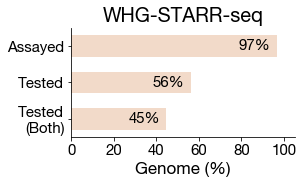

In [ ]:
plot_horizontal_bar_coverage(
    df=whg_starr_plot_df,
    x_col='Pct_genome',
    y_col='Region_type',
    order=['Assayed', 'Tested', 'Tested\n(Both)'],
    xticks=[0,20,40,60,80,100],
    xticklabels=[0,20,40,60,80,100],
    xlabel='Genome (%)',
    title='WHG-STARR-seq',
    bar_color='#f7d9c4')


## ATAC-STARR-seq

In [36]:
atac_starr_plot_df = coverage_df[(coverage_df['Dataset'].map(lambda x: 'ATAC-STARR-seq\n(Accessible Bins)' in x))]
atac_starr_plot_df


,Dataset,Region_type,Coverage_type,Number_bp,hg38_genome_size,Open_region_size,Pct_genome,Pct_open_region
7,ATAC-STARR-seq\n(Accessible Bins),Assayed,Open_region,198059816,2913022398,198066259,6.799118,99.996747
16,ATAC-STARR-seq\n(Accessible Bins),Tested,Open_region,180639582,2913022398,198066259,6.201105,91.201592
17,ATAC-STARR-seq\n(Accessible Bins),Tested\n(Both),Open_region,128182076,2913022398,198066259,4.400312,64.716765


<ipython-input-33-cb1f49a0eb72>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order, fontsize=fontsize)


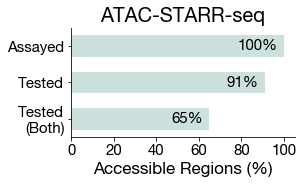

In [38]:
plot_horizontal_bar_coverage(
    df=atac_starr_plot_df,
    x_col='Pct_open_region',
    y_col='Region_type',
    order=['Assayed', 'Tested', 'Tested\n(Both)'],
    xticks=[0,20,40,60,80,100],
    xticklabels=[0,20,40,60,80,100],
    xlabel='Accessible Regions (%)',
    title='ATAC-STARR-seq',
    bar_color='#c9e4de')
